# 问题设定

在小车倒立杆（CartPole）游戏中，我们希望通过强化学习训练一个智能体（agent），尽可能不断地左右移动小车，使得小车上的杆不倒，我们首先定义CartPole游戏：

CartPole游戏即是强化学习模型的enviorment，它与agent交互，实时更新state，内部定义了reward function，其中state有以下定义：

$$
state \in \mathbb{R}^4
$$

state每一个维度分别代表了：

- 小车位置，它的取值范围是-2.4到2.4
- 小车速度，它的取值范围是负无穷到正无穷
- 杆的角度，它的取值范围是-41.8°到41.8°
- 杆的角速，它的取值范围是负无穷到正无穷

action是一个2维向量，每一个维度分别代表向左和向右移动。

$$
action \in \mathbb{R}^2
$$

小车每一次向左或向右移动都会加1分，这即是reward function，但是如果杆角度大于±12°、小车位置大于±2.4、行动次数大于200次，游戏将会结束。我们希望在游戏结束时得分尽可能大。

# 策略梯度

设计一个网络，其输入是state，输出是对应各个action的概率，并策略梯度（PolicyGradient）进行迭代训练。

我们首先定义$\tau$为一次回合的迹：

$$
\tau = \{s_1, a_1, r_1, \cdots, s_T, a_T, r_T \} \\
$$

$R(\tau)$是这次迹的奖励值之和：

$$
R(\tau) = \sum^{T}_{t=1} r_t
$$

直观地，我们希望最大化：

$$
\bar{R}_{\theta} = \sum_{\tau} R(\tau) P(\tau \lvert \theta) \approx \frac{1}{N} \sum^{N}_{n=1} R(\tau^{n})
$$

则首先对$\bar{R}_{\theta}$求梯度：

$$
\begin{align}
\nabla \bar{R}_{\theta} &= \sum_{\tau} R(\tau) \nabla P(\tau \lvert \theta)  \\
&= \sum_{\tau} R(\tau) P(\tau \lvert \theta) \cdot \frac{\nabla P(\tau \lvert \theta)}{P(\tau \lvert \theta)} \\
&= \sum_{\tau} R(\tau) P(\tau \lvert \theta) \cdot \nabla \log P(\tau \lvert \theta) \\
&\approx \frac{1}{N} \sum^{N}_{n=1} R(\tau^n) \cdot \nabla \log P(\tau^n \lvert \theta) 
\end{align}
$$

而对于$P(\tau^n \lvert \theta)$，则可以展开成以下形式：

$$
\begin{align}
p(\tau^n \lvert \theta) &= p(s_1)p(a_1 \lvert s_1, \theta)p(r_1, s_2 \lvert s_1, a_1)p(a_2 \lvert s_2, \theta) \cdots p(a_t \lvert s_t, \theta)p(r_t, s_{t+1} \lvert s_t, a_t) \\
&= p(s_1) \prod_{t} p(a_t \lvert s_t, \theta)p(r_t, s_{t+1} \lvert s_t, a_t) 
\end{align}
$$

将上式带入$\log P(\tau^n \lvert \theta)$中：

$$
\begin{align}
\nabla \log P(\tau^n \lvert \theta) &= \nabla \log \left (p(s_1) \prod_{t} p(a_t \lvert s_t, \theta)p(r_t, s_{t+1} \lvert s_t, a_t) \right) \\
&= \nabla \log p(s_1) + \sum^{T}_{t=1} \nabla \log p(a_t \lvert s_t, \theta) + \sum^{T}_{t=1}  \nabla p(r_t, s_{t+1} \lvert s_t, a_t) \\
&= \sum^{T}_{t=1} \nabla  \log p(a_t \lvert s_t, \theta)
\end{align}
$$

最终$\nabla \bar{R}_{\theta}$将改写为：

$$
\begin{align}
\nabla \bar{R}_{\theta} &\approx \frac{1}{N} \sum^{1}_{N} R(\tau^n) \cdot \nabla \log P(\tau^n \lvert \theta) \\
&= \frac{1}{N} \sum^{N}_{n=1} R(\tau^n) \sum^{T_n}_{t=1} \nabla  \log p(a_t \lvert s_t, \theta) \\
&= \frac{1}{N} \sum^{N}_{n=1} \sum^{T_n}_{t=1} R(\tau^n) \nabla  \log p(a_t \lvert s_t, \theta)
\end{align}
$$

本质上是最小化N回合采样出的action与网络输出的action的交叉熵的基础上乘以$R(\tau^n)$：

$$
- \sum^{N}_{n=1} R(\tau^n) \cdot a_i \log p_i
$$

需要注意的是，$R(\tau^n)$对于不同的问题计算方式是不同的，在CartPole中，我们更关注回合开始时的奖励，因为他们直接影响了我们是否有机会进行更可能多的动作，所以在这个问题中，$R(\tau^n)$是这样计算的：

```
# Copy r_buffer
r_buffer = self.r_buffer
# Init r_tau
r_tau = 0
# Calculate r_tau
for index in reversed(range(0, len(r_buffer))):
    r_tau = r_tau * self.gamma + r_buffer[index]
```

# 代码实现

首先导入必要包：

In [4]:
import tensorflow as tf
import numpy as np
import gym
import sys

sys.path.append('.')

实现Agent类：

In [15]:
class Agent(object):

    def __init__(self, a_space, s_space, **options):

        self.session = tf.Session()

        self.a_space, self.s_space = a_space, s_space

        self.s_buffer, self.a_buffer, self.r_buffer = [], [], []

        self._init_options(options)
        self._init_input()
        self._init_nn()
        self._init_op()

    def _init_input(self):
        self.s = tf.placeholder(tf.float32, [None, self.s_space])
        self.r = tf.placeholder(tf.float32, [None, ])
        self.a = tf.placeholder(tf.int32, [None, ])

    def _init_nn(self):
        # Kernel init.
        w_init = tf.random_normal_initializer(.0, .3)
        # Dense 1.
        dense_1 = tf.layers.dense(self.s,
                                  32,
                                  tf.nn.relu,
                                  kernel_initializer=w_init)
        # Dense 2.
        dense_2 = tf.layers.dense(dense_1,
                                  32,
                                  tf.nn.relu,
                                  kernel_initializer=w_init)
        # Action logits.
        self.a_logits = tf.layers.dense(dense_2,
                                        self.a_space,
                                        kernel_initializer=w_init)
        # Action prob.
        self.a_prob = tf.nn.softmax(self.a_logits)

    def _init_op(self):
        # One hot action.
        action_one_hot = tf.one_hot(self.a, self.a_space)
        # Calculate cross entropy.
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=action_one_hot, logits=self.a_logits)
        self.loss_func = tf.reduce_mean(cross_entropy * self.r)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_func)
        self.session.run(tf.global_variables_initializer())

    def _init_options(self, options):

        try:
            self.learning_rate = options['learning_rate']
        except KeyError:
            self.learning_rate = 0.001

        try:
            self.gamma = options['gamma']
        except KeyError:
            self.gamma = 0.95

    def predict(self, state):
        action_prob = self.session.run(self.a_prob, feed_dict={self.s: state[np.newaxis, :]})
        return np.random.choice(range(action_prob.shape[1]), p=action_prob.ravel())

    def save_transition(self, state, action, reward):
        self.s_buffer.append(state)
        self.a_buffer.append(action)
        self.r_buffer.append(reward)

    def train(self):
        # Copy r_buffer
        r_buffer = self.r_buffer
        # Init r_tau
        r_tau = 0
        # Calculate r_tau
        for index in reversed(range(0, len(r_buffer))):
            r_tau = r_tau * self.gamma + r_buffer[index]
            self.r_buffer[index] = r_tau
        # Minimize loss.
        _, loss = self.session.run([self.train_op, self.loss_func], feed_dict={
            self.s: self.s_buffer,
            self.a: self.a_buffer,
            self.r: self.r_buffer,
        })

        self.s_buffer, self.a_buffer, self.r_buffer = [], [], []

# 实验结果

通过`gym`初始化`CartPole`游戏环境并执行训练：

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make('CartPole-v0')
env.seed(1)
env = env.unwrapped

model = Agent(env.action_space.n, env.observation_space.shape[0])

r_sum_list, r_episode_sum = [], None

for episode in range(500):
    # Reset env.
    s, r_episode = env.reset(), 0
    # Start episode.
    while True:
        # if episode > 80:
        #     env.render()
        # Predict action.
        a = model.predict(s)
        # Iteration.
        s_n, r, done, _ = env.step(a)
        if done:
            r = -5
        r_episode += r
        # Save transition.
        model.save_transition(s, a, r)
        s = s_n
        if done:
            if r_episode_sum is None:
                r_episode_sum = sum(model.r_buffer)
            else:
                r_episode_sum = r_episode_sum * 0.99 + sum(model.r_buffer) * 0.01
            r_sum_list.append(r_episode_sum)
            break
    # Start train.
    model.train()
    if episode % 50 == 0:
        print("Episode: {} | Reward is: {}".format(episode, r_episode))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode: 0 | Reward is: 17.0
Episode: 50 | Reward is: 71.0
Episode: 100 | Reward is: 26.0
Episode: 150 | Reward is: 50.0
Episode: 200 | Reward is: 102.0
Episode: 250 | Reward is: 194.0
Episode: 300 | Reward is: 197.0
Episode: 350 | Reward is: 71.0
Episode: 400 | Reward is: 147.0
Episode: 450 | Reward is: 182.0


最后绘制出回合与奖励函数的曲线：

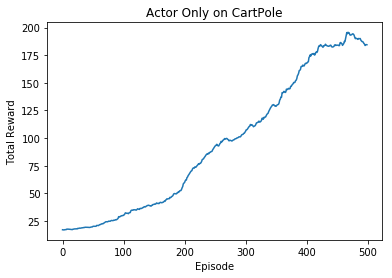

In [14]:
plt.plot(np.arange(len(r_sum_list)), r_sum_list)
plt.title('Actor Only on CartPole')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()